Идентификация пользователей по посещенным веб-страницам

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет.

Мы будем решать следующую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Имеются данные с прокси-серверов Университета Блеза Паскаля, они имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:

*timestamp, посещенный веб-сайт*

Данные устроены следующем образом:

В каталоге 10users лежат 10 csv-файлов с названием вида "user[USER_ID].csv", где [USER_ID] – ID пользователя;
Аналогично для каталога 150users – там 150 файлов;
В каталоге 3users – игрушечный пример из 3 файлов для отладки кода предобработки

Для воспроизводимости работы отобразим текущую версию используемых в работе инструментов

In [301]:
%load_ext watermark

In [302]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn 

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy      : 1.20.3
scipy      : 1.7.1
pandas     : 1.3.4
matplotlib : 3.4.3
statsmodels: 0.12.2
sklearn    : 0.24.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 8.1
Machine     : AMD64
Processor   : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores   : 4
Architecture: 64bit



Импортируем необходимые библиотеки

In [3]:
import re
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import itertools
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler

Посмотрим на один из файлов 

In [7]:
PATH_TO_DATA = r"E:\Work\Project_capstone"

In [305]:
user0031_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       r'10users\user0031.csv'))

In [306]:
user0031_data.head(10)

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net
5,2013-11-15 08:12:38,www.laposte.net
6,2013-11-15 08:12:39,www.google.com
7,2013-11-15 08:12:39,www.laposte.net
8,2013-11-15 08:12:40,match.rtbidder.net
9,2013-11-15 08:12:40,www.laposte.net


In [307]:
user0031_data.describe()

,timestamp,site
count,7600,7600
unique,4321,962
top,2014-03-20 11:02:20,webmail.laposte.net
freq,20,399


Напишу функцию которая принимает на вход путь к каталогу с csv файлами, путь к частотному словарю с сайтами, и длину сессии, а возвращает датафрейм,
в котором строки соответствуют сессиям из сайтов, содержащихся в session_length столбцов – индексам
этих session_length сайтов и последний столбец – ID пользователя
частотный словарь сайтов

Функция для создания частотного словаря, содержащего в качестве ключей названия уникальных сайтов, а в качестве значений - уникальный присвоенный нами id и частота встречаемости сайта во всей  подвыборке:

In [592]:
from collections import Counter
def create_frequency_dict(path_to_csv_files):
    #создаем циклом словарь уникальных значений сайтов
    global frequency
    prepaired_df = pd.DataFrame()   
    frequency = Counter()
    for filename in glob(f'{path_to_csv_files}/*'):
        iter_df = pd.read_csv(filename)
        value_counts_dict = iter_df['site'].value_counts().to_dict()
        #обновляем словарь частот для каждого файла
        frequency.update(value_counts_dict)
      #Присваиваем ключи словарю
    frequency = dict(frequency)   
    return frequency

Загрузим частотные словари с сайтами на жёсткий диск в виде pickle файлов для дальнейшего использования в функциях

In [595]:
site_freq_10users = create_frequency_dict(os.path.join(PATH_TO_DATA, 
                                       '10users'))
pickle.dump(site_freq_10users, open( "site_freq_10users.pkl", "wb"))

site_freq_3users = create_frequency_dict(os.path.join(PATH_TO_DATA, 
                                       '3users'))
pickle.dump(site_freq_3users, open( "site_freq_3users.pkl", "wb"))

site_freq_150users = create_frequency_dict(os.path.join(PATH_TO_DATA, 
                                       '150users'))
pickle.dump(site_freq_10users, open( "site_freq_150users.pkl", "wb"))

Функция для преобразования набора данных так, чтобы он был разделён на сессии

In [597]:
def prepare_train_set(path_to_csv_files, path_to_frequency_dict, session_length):
    #инициализируем датафрейм 
    global prepaired_df
    prepaired_df = pd.DataFrame()
    frequency = pd.read_pickle(path_to_frequency_dict)
    i = 0
    for key, value in frequency.items():
        i += 1
        frequency[key] =[i, value]
    #Создаём prepared train set
    for filename in glob(f'{path_to_csv_files}/*'):
        #создаем датафрейм для каждого файла
        iter_df = pd.read_csv(filename)
        if len(iter_df) % session_length == 0:
            iter_df_len = len(iter_df) // session_length
        elif len(iter_df) % session_length != 0:
            iter_df_len = len(iter_df) // session_length + 1      
        #ищем номер пользователя и инициализируем соответствующую серию
        iter_new_df = pd.DataFrame(0, index=np.arange(iter_df_len), columns=["user_id"])
        session_id = re.findall("(\d{4}).{4}", filename)
        iter_new_df["user_id"] = str(session_id)
        #Инициализируем столбцы с сайтами сессии                               
        for i in range(1, session_length + 1):
            iter_new_df["site_"+ str(i)] = 0
            iter_site_column = iter_new_df["site_"+ str(i)] 
            #для каждого столбца создадим список айди сайтов
            n = 0
            for column_id in range(i-1, len(iter_df["site"]), session_length):
            #key - названия сайтов в исходной таблице
                key = iter_df["site"][column_id]
                iter_site_column[n] = frequency[key][0]
                n += 1
        prepaired_df = pd.concat([prepaired_df, iter_new_df])
    prepaired_df.index = range(1, len(prepaired_df.index) + 1)
    prepaired_df.index.rename("session_id", inplace = True)
        #Соединяем датафреймы по иерациям glob
    return prepaired_df



In [ ]:
prepare_sparse_train_set_window_new(os.path.join(PATH_TO_DATA, 
                                       '10users'),os.path.join(PATH_TO_DATA, 
                                       'site_freq_10users.pkl'), 10)

In [598]:
train_data_150users = prepare_train_set(os.path.join(PATH_TO_DATA, 
                                       '150users'),os.path.join(PATH_TO_DATA, 
                                       'site_freq_150users.pkl'), 10)
train_data_150users

,user_id,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10
session_id,,,,,,,,,,,
1,['0006'],6,6,7,8,6,7,6,8,186,119
2,['0006'],8,31,187,186,119,119,76,50,54,54
3,['0006'],119,147,6,6,6,6,50,119,8,6
4,['0006'],6,6,230,230,455,230,230,6,423,6
5,['0006'],6,6,18,6,12,10,12,10,44,18
...,...,...,...,...,...,...,...,...,...,...,...
137015,['2902'],635,1474,1319,1568,635,1590,1474,1590,635,183
137016,['2902'],31,1474,183,328,1716,1568,112,8,6,1590
137017,['2902'],1590,1588,1590,1758,635,1032,251,951,1655,17


Число уникальнвх сессий из 10 сайтов среди 150 людей.

In [67]:
len(train_data_150users.loc[:,"site_1":].drop_duplicates())

131009

Всего уникальных сайтов среди 150 пользователей:

In [68]:
len(site_freq_150users)

27797

Самые популярные сайты:

In [586]:
site_freq_150users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'))

In [588]:
import operator
frequency_freq_only = {}
for key, value in site_freq_150users.items():
    frequency_freq_only.update({key: value[1]})
dict(sorted(frequency_freq_only.items(), key=operator.itemgetter(1), reverse=True)[:15])


{'www.google.fr': 64785,
 'www.google.com': 51320,
 'www.facebook.com': 39002,
 'apis.google.com': 29983,
 's.youtube.com': 29102,
 'clients1.google.com': 25087,
 'mail.google.com': 19072,
 'plus.google.com': 18467,
 'safebrowsing-cache.google.com': 17960,
 'www.youtube.com': 16319,
 'twitter.com': 16219,
 'platform.twitter.com': 15317,
 's-static.ak.facebook.com': 15048,
 'accounts.google.com': 13855,
 'www.bing.com': 13797}

Создадим разреженную матрицу для признаков 

Сделаем число сайтов в сессии и их распределение параметрами чтобы в дальнейшем сравнить модели классификации, обученные на различных session_length и window_size. Попробуем сделать сессии пересекающимися и подкорректируем  функцию prepare_train_set для создания разреженного датафрейма и применим для 16 различных сочетаний session_length + window_size.

In [9]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length, window_size):
    # Инициализируем заготовку для будущего разреженного фрейма и словарь с сайтами
    global X_sparse
    global y
    prepaired_df = pd.DataFrame()   
    site_freq_dict = pd.read_pickle(site_freq_path)
    #Перебираем сайты из каталога по одному
    for filename in glob(f'{path_to_csv_files}/*'):
        #создаем датафрейм для каждого файла
        iter_df = pd.read_csv(filename)     
        #ищем номер пользователя и инициализируем y нулями
        new_df_len = (len(iter_df) // window_size) + 1
        new_df = pd.DataFrame(0, index=np.arange(new_df_len), columns=["user_id"])
        session_id = re.findall("(\d{4}).{4}", filename)
        new_df["user_id"] = str(session_id)
        #Инициализируем столбцы с сайтами сессии                               
        for i in range(1, session_length + 1):
            new_df["site_"+ str(i)] = 0
            iter_site_column = new_df["site_"+ str(i)] 
            #для каждого столбца создадим список айди сайтов
            n = 0
            for session_start_id in range(i-1, len(iter_df), window_size):
            #key - названия сайтов в iter_df
                key = iter_df["site"][session_start_id]
                iter_site_column[n] = site_freq_dict[key][0]
                n += 1
        if (new_df.iloc[-1, 1:] == 0).all():
            new_df.drop(new_df.tail(1).index,inplace=True)
        prepaired_df = pd.concat([prepaired_df, new_df])
        X, y = prepaired_df.iloc[:, 1:].values, \
                   prepaired_df.iloc[:, 0].values
        indptr = list(range(0, len(X)* session_length + 1,   session_length))
        indices = list(np.concatenate(X, axis=0 ))
        data = list(np.ones( len(X)* session_length))
        X_sparse = csr_matrix((data, indices, indptr), dtype=int)
        X_sparse = X_sparse[:,1:]
    
    return  prepaired_df, X_sparse, y

In [ ]:
X_train, X_valid, y_train, y_valid = train_test

In [10]:
prepaired_df, X_sparse, y = prepare_sparse_train_set_window(r"E:\Work\Project_capstone\10users",
                                              r"E:\Work\Project_capstone\site_freq_10users.pkl", 16, 6)

In [12]:
prepaired_df

,user_id,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,site_11,site_12,site_13,site_14,site_15,site_16
0,['0031'],101,65,10,4,10,10,4,10,74,10,68,62,130,271,10,24
1,['0031'],4,10,74,10,68,62,130,271,10,24,40,766,32,1,1,4
2,['0031'],130,271,10,24,40,766,32,1,1,4,1,1,8,87,68,97
3,['0031'],32,1,1,4,1,1,8,87,68,97,232,1,109,767,109,1
4,['0031'],8,87,68,97,232,1,109,767,109,1,1,1,1,405,18,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,['0241'],44,4,7,2,7,44,45,7,2,6,17,75,2,45,7,7
885,['0241'],45,7,2,6,17,75,2,45,7,7,7,7,7,72,75,7
886,['0241'],2,45,7,7,7,7,7,72,75,7,4,4,2,7,17,69
887,['0241'],7,72,75,7,4,4,2,7,17,69,0,0,0,0,0,0


Проверим работу на игрушечных данных

In [667]:
prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, 
                                       "3users"), os.path.join(PATH_TO_DATA, "site_freq_3users.pkl"), 
                                    5 ,3)

(<12x11 sparse matrix of type '<class 'numpy.intc'>'
 	with 49 stored elements in Compressed Sparse Row format>,
 array(["['0001']", "['0001']", "['0001']", "['0001']", "['0001']",
        "['0002']", "['0002']", "['0003']", "['0003']", "['0003']",
        "['0003']", "['0003']"], dtype=object))

In [651]:
feature_engineering(os.path.join(PATH_TO_DATA, 
                                       "150users"), 5, 10)

,user_id,avg_time_on_site,session_timestamp,unique_sites,start_hour,day_of_week
0,['0006'],5,57.0,5,8,4
1,['0006'],8,87.0,7,8,4
2,['0006'],162,1620.0,8,8,4
3,['0006'],161,1616.0,6,8,4
4,['0006'],202,2027.0,5,8,4
...,...,...,...,...,...,...
1350,['2902'],0,6.0,9,17,0
1351,['2902'],0,2.0,9,17,0
1352,['2902'],0,6.0,9,17,0
1353,['2902'],603687,3018437.0,7,17,0


Улучшим функцию, увеличив скорость её работы

In [9]:
%%time
def prepare_sparse_train_set_window_new(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    files = glob(path_to_csv_files + "/*.csv")
    
    with open(site_freq_path, 'rb') as f:
        dict_freq = pickle.load(f)
    sessions = []
    users = []
    
    for i, file in enumerate(files):
        user = re.findall("(\d{4}).{4}", file)
        user_session = pd.read_csv(file, index_col=None, header=0).iloc[:, 1]
        cur_session = []
        index = 0
        
        while index < len(user_session):
            for j in range(index, min(index + session_length, len(user_session))):
                cur_session.append(dict_freq[user_session[j]][0])
                
            while len(cur_session) < session_length: cur_session.append(0)
            
            sessions.append(cur_session)
            users.append(user)
            
            index += window_size
            cur_session = []
            
    train_set = pd.DataFrame(sessions)
    X_users = train_set.iloc[:, :-1].values
    
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    
    for x in X_users:
        for term in x:
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
        
    X_sparse = csr_matrix((data, indices, indptr))[:, 1:]
    
    return X_sparse, np.array(users)

Wall time: 0 ns


Запустим функцию 16 раз с различными значениями session_length и window_size

In [682]:
import itertools

for num_users in [10, 150]:
    for session_length, window_size in itertools.product([15, 10, 7, 5], [10, 7, 5]):
        if window_size <= session_length:
            X_sparse, y = prepare_sparse_train_set_window_new(os.path.join(PATH_TO_DATA, 
                                       str(num_users) + "users"), os.path.join(PATH_TO_DATA, "site_freq_" + str(num_users) + "users.pkl"), 
                                    session_length , window_size )
            pickle.dump(X_sparse, open(os.path.join(PATH_TO_DATA,"X_sparse_"+ str(num_users) + "users_s" + str(session_length) +"_w" + str(window_size) +".pkl"), 'wb'))
            pickle.dump(y, open(os.path.join(PATH_TO_DATA, "y" + "_" + str(num_users) + "users_s" + str(session_length) +"_w" + str(window_size) +".pkl"), 'wb'))


In [750]:
X_train, X_valid, y_train, y_valid = train_test_split(pd.read_pickle(os.path.join(PATH_TO_DATA, "X_sparse_10users_s10_w10.pkl")), 
                                                      pd.read_pickle(os.path.join(PATH_TO_DATA, "y_10users_s10_w10.pkl")), 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users_10_10_)

In [753]:
X = pd.read_pickle(os.path.join(PATH_TO_DATA, "X_sparse_10users_s10_w10.pkl"))


In [754]:
y = pd.read_pickle(os.path.join(PATH_TO_DATA, "y_10users_s10_w10.pkl"))

Исследудуем имеющиеся данные по 10 пользователям

In [278]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [279]:
train_df.head()

,user_id,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10
session_id,,,,,,,,,,,
1,['0031'],101,65,10,4,10,10,4,10,74,10
2,['0031'],68,62,130,271,10,24,40,766,32,1
3,['0031'],1,4,1,1,8,87,68,97,232,1
4,['0031'],109,767,109,1,1,1,1,405,18,9
5,['0031'],103,1,8,768,33,30,769,314,110,314


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 1 to 14061
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14061 non-null  object
 1   site_1   14061 non-null  int64 
 2   site_2   14061 non-null  int64 
 3   site_3   14061 non-null  int64 
 4   site_4   14061 non-null  int64 
 5   site_5   14061 non-null  int64 
 6   site_6   14061 non-null  int64 
 7   site_7   14061 non-null  int64 
 8   site_8   14061 non-null  int64 
 9   site_9   14061 non-null  int64 
 10  site_10  14061 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 1.3+ MB


Распределение целевого класса:

(array([ 760., 1022., 2204.,  802.,  720., 1712., 2796., 1868., 1643.,
         534.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

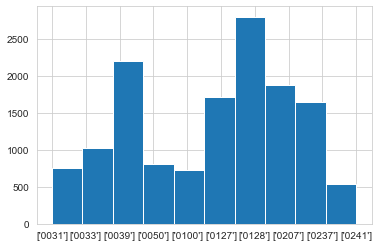

In [281]:
plt.hist(train_df['user_id'])

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

In [283]:
num_unique_sites = [np.unique(train_df.values[i, 1:]).shape[0] 
                    for i in range(train_df.shape[0])]

In [284]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

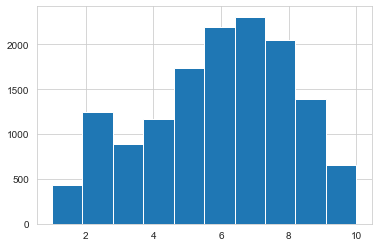

In [285]:
pd.Series(num_unique_sites).hist();

Проверим с помощью критерия Шапиро-Уилка, что эта величина распределена нормально

In [290]:
import scipy

In [291]:
scipy.stats.shapiro(pd.Series(num_unique_sites))

ShapiroResult(statistic=0.9546933174133301, pvalue=0.0)

Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт больше 95% 

In [293]:
has_two_similar = (np.array(num_unique_sites) < 10).astype("int")

In [294]:
type(has_two_similar)

numpy.ndarray

In [295]:
np.count_nonzero(has_two_similar == 1)

13410

In [296]:
scipy.stats.binomtest(np.count_nonzero(has_two_similar == 1), len(has_two_similar), p=0.95, alternative='greater').pvalue

0.02207653769039079

Доля случаев когда пользователь повторно посетил в сессии сайт - больше 95%

95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт:

In [298]:
from math import sqrt
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

In [299]:
positive = np.count_nonzero(has_two_similar == 1)
total = len(has_two_similar)
p = positive/total
wilson_interval = wilson(p, total)

In [300]:
wilson_interval

(0.9501028156707213, 0.9570527970878326)

In [43]:
print('{} {}'.format(round(wilson_interval[0], 3),
                                   round(wilson_interval[1], 3)))

0.95 0.957


Распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [301]:
freq_dict = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))
                    

In [304]:
freq_dict

{'webmail.laposte.net': [1, 399],
 'plus.google.com': [2, 2630],
 'live.lemde.fr': [3, 274],
 'www.google.com': [4, 5441],
 'www.google.fr': [5, 7813],
 'apis.google.com': [6, 3758],
 'mail.google.com': [7, 4158],
 'www.facebook.com': [8, 4141],
 'av.mediapostcommunication.net': [9, 133],
 'www.laposte.net': [10, 119],
 'fr.massivetriviaquiz.com': [11, 111],
 'clients1.google.com': [12, 1493],
 '160.92.123.193': [13, 91],
 'www.lequipe.fr': [14, 90],
 'safebrowsing-cache.google.com': [15, 1039],
 'ws.mediapostcommunication.net': [16, 86],
 'accounts.google.com': [17, 2089],
 'rs.mediapostcommunication.net': [18, 85],
 's-static.ak.facebook.com': [19, 1388],
 'news.google.fr': [20, 72],
 'static.ak.facebook.com': [21, 1265],
 'twitter.com': [22, 1204],
 'www.youtube.com': [23, 1804],
 'ajax.googleapis.com': [24, 711],
 'cloudfront.cedexis.com': [25, 76],
 'static.s-sfr.fr': [26, 51],
 'hal9000.redintelligence.net': [27, 162],
 'www.journaldesfemmes.com': [28, 50],
 'safebrowsing.clients

In [302]:
top_sites_counts_dict = {}
for value in freq_dict.values():
    if value[1] >= 1000:
        top_sites_counts_dict.update({value[0]: value[1]})
top_sites_counts_dict

Инициализируем функцию для создания признаков 

In [10]:
def feature_engineering(path_to_csv_files, session_length, window_size):
    global prepaired_df
    # Инициализируем заготовку для будущего разреженного фрейма и словарь с сайтами
    prepaired_df = pd.DataFrame()   
    #Перебираем сайты из каталога по одному
    for filename in glob(f'{path_to_csv_files}/*'):
        #создаем датафрейм для каждого файла
        iter_df = pd.read_csv(filename, encoding = 'unicode_escape')    
        iter_df["timestamp"] = pd.to_datetime(iter_df["timestamp"])
         #Инициализируем столбцы с признаками
        new_df = pd.DataFrame(columns=["avg_time_on_site", "session_timestamp"
                              ,"unique_sites" ,"start_hour" ,"day_of_week"] )
        #Создаём признаки помимо сайта на определённой позиции в сессии
       
        #СОздаём признаки построчно
        for new_df_string_id, ses_start_iter_id in enumerate(range(0, len(iter_df), window_size)):
            #Зададим начальную и конечную дату сессии для вычисления размера интервала между ними
            if (len(iter_df)-1 - ses_start_iter_id) >= session_length:
                future_date = iter_df["timestamp"][ses_start_iter_id + session_length]
            else:
                future_date = iter_df["timestamp"][len(iter_df)-1]
            past_date = iter_df["timestamp"][ses_start_iter_id]
            session_timestamp = (future_date-past_date).total_seconds()
            
            #Сколько раз встречается самый популярный сайт в сессии
            #sess_mode = iter_df["site"].iloc[ses_start_iter_id : ses_start_iter_id + window_size].mode()
            #count_mode = iter_df["site"].iloc[ses_start_iter_id : ses_start_iter_id + window_size].count(sess_mode)
            #new_df["mode_site_count"][new_df_string_id] = count_mode
            #Задаём число итераций цикла для avg_time_on_site
            
            if (len(iter_df)-1 - ses_start_iter_id) < session_length:
                new_session_length = len(iter_df["timestamp"].iloc[ses_start_iter_id:len(iter_df)])-1
            else:
                new_session_length = session_length 
            avg_time_on_site_array = []
            for i in range(ses_start_iter_id+1, ses_start_iter_id+1 + new_session_length):
                avg_time_on_site_array.append((iter_df["timestamp"][i] - iter_df["timestamp"][i-1]).total_seconds()) 
            if new_session_length == session_length: 
                avg_time_on_site = int(sum(avg_time_on_site_array) / len(avg_time_on_site_array))
            elif new_session_length == len(iter_df["timestamp"].iloc[ses_start_iter_id:len(iter_df)])-1:
                if len(avg_time_on_site_array)-1 == 0:
                    avg_time_on_site = int(sum(avg_time_on_site_array))
                else:
                    avg_time_on_site = int(sum(avg_time_on_site_array) / (len(avg_time_on_site_array)-1))
                
            unique_sites = iter_df["site"].iloc[ses_start_iter_id : ses_start_iter_id + session_length].nunique()
            start_hour = iter_df["timestamp"][ses_start_iter_id].hour
            day_of_week = iter_df["timestamp"][ses_start_iter_id].weekday()
            
            new_df = new_df.append({"avg_time_on_site": avg_time_on_site, "session_timestamp": session_timestamp,
                          "unique_sites": unique_sites ,"start_hour": start_hour ,"day_of_week": day_of_week}, ignore_index=True)
        prepaired_df = pd.concat([prepaired_df, new_df])
    
    return prepaired_df

Проверим рабоу функции на датасетах из трёх и десяти пользователей

In [ ]:
features_3users_5_3 = feature_engineering(os.path.join(PATH_TO_DATA, 
         '3users'), 5, 3)

In [ ]:
features_3users_5_3

In [691]:
len(pd.read_pickle(r"E:\Work\Kaggle_competitions\User_identification\capstone_user_identification\y_10users_10_10.pkl"))

14061

In [706]:
user0241 = pd.read_csv(r"E:\Work\Kaggle_competitions\User_identification\capstone_user_identification\10users\user0241.csv")

In [707]:
len(user0241)

5332

In [709]:
user0241.tail(12)

,timestamp,site
5320,2014-03-26 15:39:55,mail.google.com
5321,2014-03-26 15:39:57,mail.google.com
5322,2014-03-26 15:39:58,mail.google.com
5323,2014-03-26 15:40:49,ieonline.microsoft.com
5324,2014-03-26 15:43:42,drive.google.com
5325,2014-03-26 15:43:43,mail.google.com
5326,2014-03-26 15:43:55,www.google.com
5327,2014-03-26 15:43:56,www.google.com
5328,2014-03-26 15:43:57,plus.google.com
5329,2014-03-26 15:43:57,mail.google.com


In [700]:
features_10users_10_10_

,avg_time_on_site,session_timestamp,unique_sites,start_hour,day_of_week
0,3,33.0,5,8,4
1,31,285.0,10,8,4
2,28,258.0,7,8,4
3,3,30.0,6,8,4
4,0,7.0,9,8,4
...,...,...,...,...,...
14056,3,32.0,8,15,2
14057,1,12.0,8,15,2
14058,1,17.0,6,15,2
14059,26,243.0,5,15,2


In [701]:
features_10users_10_10

,user_id,avg_time_on_site,session_timestamp,unique_sites,start_hour,day_of_week
0,['0031'],3,33.0,5,8,4
1,['0031'],28,285.0,10,8,4
2,['0031'],25,258.0,7,8,4
3,['0031'],3,30.0,6,8,4
4,['0031'],0,7.0,9,8,4
...,...,...,...,...,...,...
529,['0241'],3,32.0,8,15,2
530,['0241'],1,12.0,8,15,2
531,['0241'],1,17.0,6,15,2
532,['0241'],24,243.0,5,15,2


Будем исследовать обнаруженные значения признаков на наборе данных из 10 пользователей

In [710]:
new_features_10users_10_10 = pd.read_pickle(os.path.join(PATH_TO_DATA, r"features_10users_10_10.pkl"))


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Work\\Project_capstone\\features_10users_10_10.pkl'

In [673]:
new_features_10users_10_10

,user_id,avg_time_on_site,session_timestamp,unique_sites,start_hour,day_of_week
0,['0031'],3,33.0,5,8,4
1,['0031'],31,285.0,10,8,4
2,['0031'],28,258.0,7,8,4
3,['0031'],3,30.0,6,8,4
4,['0031'],0,7.0,9,8,4
...,...,...,...,...,...,...
14056,['0241'],3,32.0,8,15,2
14057,['0241'],1,12.0,8,15,2
14058,['0241'],1,17.0,6,15,2
14059,['0241'],26,243.0,5,15,2


Посмотрим, каково распределение частот значений длины сессии

In [229]:
new_features_10users_10_10["session_timestamp"].value_counts()

2.0          641
3.0          535
4.0          409
1.0          372
5.0          339
            ... 
77424.0        1
195705.0       1
242978.0       1
159845.0       1
2735739.0      1
Name: session_timestamp, Length: 1971, dtype: int64

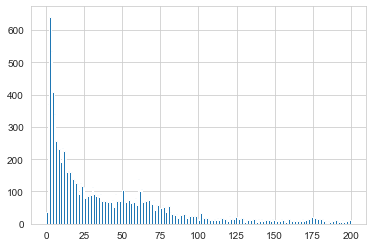

In [334]:
plt.hist(new_features_10users_10_10["session_timestamp"], bins = 200, range = (0, 200))

plt.show()

Гистограмма распределения числа уникальных сайтов в сессии (unique_sites).

Text(0, 0.5, 'Количество')

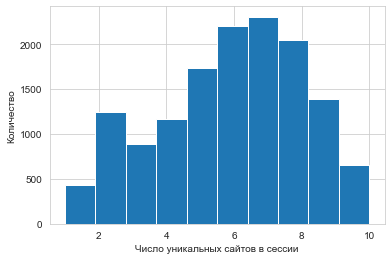

In [329]:
plt.hist(new_features_10users_10_10["unique_sites"])
plt.xlabel("Число уникальных сайтов в сессии")
plt.ylabel("Количество")

Распределения часа начала сессии (start_hour)

In [342]:
new_features_10users_10_10["start_hour"].value_counts()

14    1872
15    1409
10    1296
13    1283
9     1264
12    1160
16     947
11     920
17     879
8      770
20     519
18     500
19     456
21     423
22     239
23     118
7        5
Name: start_hour, dtype: int64

Text(0, 0.5, 'Количество')

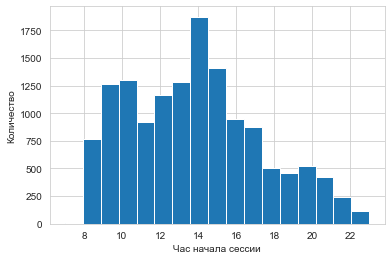

In [343]:
plt.hist(new_features_10users_10_10["start_hour"], bins = len(new_features_10users_10_10["start_hour"].value_counts()), 
         range = (7, 23))
plt.xlabel("Час начала сессии")
plt.ylabel("Количество")

Распределения дня недели, в который началась сессия

In [347]:
new_features_10users_10_10["day_of_week"].value_counts()

2    3163
1    2772
3    2316
4    1519
0    1505
5    1494
6    1291
Name: day_of_week, dtype: int64

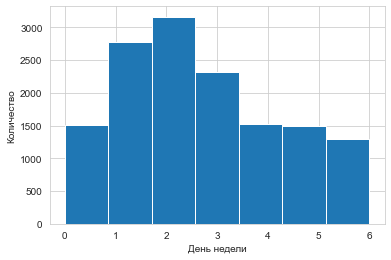

In [353]:
plt.hist(new_features_10users_10_10["day_of_week"], bins = len(new_features_10users_10_10["day_of_week"].value_counts()), 
         range = (0, 6))

plt.xlabel("День недели")
plt.ylabel("Количество")
plt.show()

Загрузим сериализованные ранее объекты X_sparse_10users и y_10users, соответствующие обучающей выборке для 10 пользователей. Будем подбирать лучшую модель на ней, а не на выборке по 150 пользователям.

In [56]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users_10_10.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users_10_10 = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users_10_10.pkl'), 'rb') as y_10users_pkl:
    y_10users_10_10 = pickle.load(y_10users_pkl)

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_sparse_10users_10_10, y_10users_10_10, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users_10_10)

Зададим параметры кросс-валидации

In [58]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [59]:
StratifiedKFold?

Создадим функцию для отрисовки кривых валидации

In [60]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Значение accuracy knn для 10 пользователей на X_train на кросс-валидации: 

In [63]:
KNeighborsClassifier?

In [62]:
knn = KNeighborsClassifier(n_neighbors=100)

In [201]:
list_accu_stratified_train = []
  
for train_indexes, test_indexes in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_indexes], X_train[test_indexes]
    y_train_fold, y_test_fold = y_train[train_indexes], y_train[test_indexes]
    knn.fit(X_train_fold, y_train_fold)
    list_accu_stratified_train.append(knn.score(X_test_fold, y_test_fold))
print("Значение accuracy на X_train на кросс-валидации: ")
print(list_accu_stratified_train)

Значение accuracy на X_train на кросс-валидации: 
[0.9963772196568683, 0.9961707399481924, 0.9966024064723218]


In [70]:
knn_params1 = [5, 20, 50, 100, 250, 500, 1000, 1500, 2000, 5000, 25000]

In [200]:
GridSearchCV?

In [71]:
knn_grid_search1 = GridSearchCV(estimator = knn, param_grid = knn_params1, return_train_score = True)

AttributeError: 'int' object has no attribute 'items'

Значение accuracy на отложенной выборке

In [202]:
accuracy_score(y_test_fold, knn.fit(X_train_fold, y_train_fold).predict(X_test_fold))

0.9966024064723218

Случайный лес:

In [285]:
rf = RandomForestClassifier(oob_score = True, random_state = 17, n_jobs=-1)

In [721]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=17)

In [725]:
accuracy_score(y_test, forest.predict(X_test))

0.7245792841905665

Out of bag error тренировочная подвыборка:

In [726]:
rf.oob_score_

0.7054460475513107

Out of bag error тестовая подвыборка:

In [290]:
rf.fit(X_test, y_test).oob_score_

0.6906849964446551

Логистическая регрессияя:

In [69]:
lr = LogisticRegression(random_state=17, n_jobs=-1)

Подберём оптимальный параметр C

In [792]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(cv = 5, Cs = logit_c_values1, multi_class = "multinomial").fit(X_train, y_train)



Wall time: 57.3 s


Функция находит среднее значение точности  по результатам кросс-валидации для всех перебираемых значений величины регуляризации в течение пяти итераций кросс-валидации

In [773]:
dict_cv_scores = logit_grid_searcher1.scores_
list_of_cv_scores = next(iter(dict_cv_scores.values()))
array_all_cv_results = []

for counter in range(len(list_of_cv_scores[0])):
    array_cv_results = []
    for i in range(len(list_of_cv_scores)):
        array_cv_results.append(list_of_cv_scores[i][counter])
    mean_iter_array = sum(array_cv_results)/len(array_cv_results)
    array_all_cv_results.append(mean_iter_array)
    
print(array_all_cv_results)
print( np.logspace(-4, 2, 10))

[0.3099975948337442, 0.4691114201009963, 0.5446040662793626, 0.6460058756250335, 0.7116434304896629, 0.7458854624732129, 0.7564518842877611, 0.7525907666390022, 0.7479169505382205, 0.7417194151626635]
[1.00000000e-04 4.64158883e-04 2.15443469e-03 1.00000000e-02
 4.64158883e-02 2.15443469e-01 1.00000000e+00 4.64158883e+00
 2.15443469e+01 1.00000000e+02]


Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение коэффициента регуляризации

In [774]:
print("Accuracy: " + str(max(array_all_cv_results)))
print("C: " + str(np.logspace(-4, 2, 10)[array_all_cv_results.index(max(array_all_cv_results))]))

Accuracy: 0.7564518842877611
C: 1.0


Лучший коэффициен регуляризации - это 1

Графики зависимости точности модели от величины C для тренировочной выборки

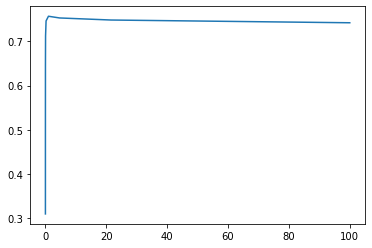

In [776]:
plt.plot(np.logspace(-4, 2, 10), array_all_cv_results)


(0.0, 10.0)

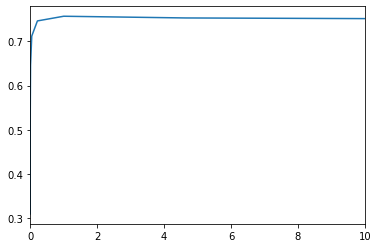

In [777]:
plt.plot(np.logspace(-4, 2, 10), array_all_cv_results)
plt.xlim([0, 10])

Точность логистической регрессии на тестовой выборке при C = 1:

In [74]:
accuracy_score(y_test, LogisticRegression(random_state=17, n_jobs=-1, C = 1).fit(X_train, y_train).predict(X_test))

0.7767243422611994

Продолжаем перебор параметра регуляризации

In [76]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, multi_class = "multinomial", cv = 5)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 3min 2s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=5, multi_class='multinomial')

Accuracy в зависимости от значения C

In [77]:
dict_cv_scores = logit_grid_searcher2.scores_
list_of_cv_scores = next(iter(dict_cv_scores.values()))
array_all_cv_results = []
for counter in range(len(list_of_cv_scores[0])):
    array_cv_results = []
    for i in range(len(list_of_cv_scores)):
        array_cv_results.append(list_of_cv_scores[i][counter])
    mean_iter_array = sum(array_cv_results)/len(array_cv_results)
    array_all_cv_results.append(mean_iter_array)
print(array_all_cv_results)
print( np.logspace(0.1, 7, 20))

[0.7442594978260599, 0.7656985098291815, 0.7683403217348577, 0.767933817669817, 0.7676289912340464, 0.7663084723787816, 0.7663084207657719, 0.7656986646682109, 0.7646821464405604, 0.7647835660047815, 0.7640723387299897, 0.7648851404080318, 0.764275332697461, 0.7636656798259198, 0.7632592789868987, 0.7627512521316172, 0.7627513037446272, 0.7625481033251166, 0.7621416508730856, 0.7619383472275555]
[1.25892541e+00 2.90507865e+00 6.70371881e+00 1.54694077e+01
 3.56969885e+01 8.23738707e+01 1.90084790e+02 4.38637001e+02
 1.01219260e+03 2.33572147e+03 5.38987815e+03 1.24376073e+04
 2.87008485e+04 6.62296762e+04 1.52830673e+05 3.52669921e+05
 8.13816172e+05 1.87795080e+06 4.33353297e+06 1.00000000e+07]


(0.0, 100.0)

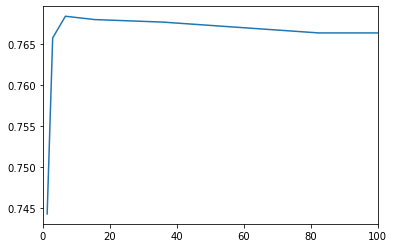

In [78]:
plt.plot(np.logspace(0.1, 7, 20), array_all_cv_results)
plt.xlim(0, 100)

Качество с лучшим C на кросс-валидации по тренировочной выборке

In [79]:
print("Accuracy: " + str(max(array_all_cv_results)))
print("C: " + str(np.logspace(0.1, 7, 20)[array_all_cv_results.index(max(array_all_cv_results))]))

Accuracy: 0.7683403217348577
C: 6.703718811765353


Точность логистической регрессии на тестовой выборке при C = 6.703718811765353:

In [43]:
lr2 = LogisticRegression(C = 6.703718811765353, random_state=17, n_jobs=-1)

In [59]:
lr2.fit(X_train_150_16_6, y_train_0128)

LogisticRegression(C=6.703718811765353, n_jobs=-1, random_state=17)

In [89]:
accuracy_score(y_test, lr2.predict(X_test))

0.7824128940507229

Обучим линейный SVM

In [91]:
svm = LinearSVC(Crandom_state = 17, multi_class = "ovr")

Подберём лучшее значение C с помощью перебора по сетке

In [92]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(estimator = svm, param_grid = svm_params1, return_train_score = True )
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 48s


GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True)

Лучшее значение C по результатам первой поверки:

In [94]:
print(svm_grid_searcher1.best_params_)
print("accuracy : ", svm_grid_searcher1.best_score_)

{'C': 4444.4445000000005}
accuracy :  0.6952843773612952


Кривые валидации для тренировочной выборки 

In [808]:
svm_params1.get("C")

array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])

In [809]:
svm_grid_searcher1.cv_results_

{'mean_fit_time': array([0.0762537 , 2.28503556, 2.2344079 , 2.31857691, 2.36016531,
        2.43246417, 2.22930264, 2.2315197 , 2.24043732, 2.23753319]),
 'std_fit_time': array([0.01191656, 0.04303963, 0.05322607, 0.07071409, 0.10578769,
        0.13221114, 0.05667025, 0.06737114, 0.05956333, 0.05359118]),
 'mean_score_time': array([0.0008007 , 0.00060039, 0.        , 0.00040073, 0.0037251 ,
        0.00100088, 0.00312557, 0.00625048, 0.00312505, 0.        ]),
 'std_score_time': array([0.00098066, 0.00080034, 0.        , 0.00080147, 0.00599488,
        0.00089516, 0.00625114, 0.00765524, 0.0062501 , 0.        ]),
 'param_C': masked_array(data=[0.0001, 1111.1112, 2222.2223000000004,
                    3333.3334000000004, 4444.4445000000005,
                    5555.555600000001, 6666.666700000001,
                    7777.777800000001, 8888.8889, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=

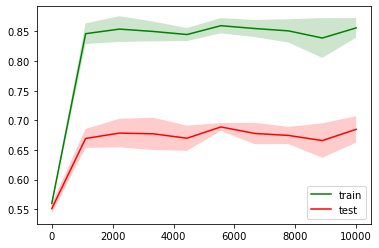

In [810]:
plot_validation_curves(svm_params1.get("C"), svm_grid_searcher1.cv_results_)

Попробуем более узкий перебор параметров для SVM

In [95]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(estimator = LinearSVC(), param_grid = svm_params2, return_train_score = True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 3min 11s


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True)

Лучшее значение C и соответствующее ему значение Accuracy на кросс-валидации по тестовой выборке

In [96]:
print(svm_grid_searcher2.best_params_)
print("accuracy : ", svm_grid_searcher2.best_score_)

{'C': 0.10434482758620689}
accuracy :  0.7701686093803548


Кривые валидации для новых перебираемых значений C

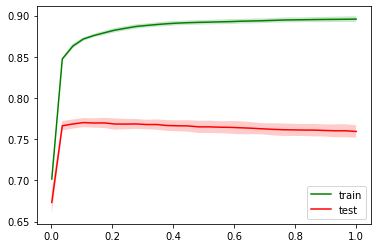

In [97]:
plot_validation_curves(svm_params2.get("C"), svm_grid_searcher2.cv_results_)



Точность Linear SVC на отложенной выборке X_valid:

In [98]:
accuracy_score(y_test, LinearSVC(C = 0.1043, random_state = 17, multi_class = "ovr").fit(X_train, y_train).predict(X_test))

0.7807537331121118

Подберём оптимальное значение window size и session_length на выборке для 10 пользователей

In [ ]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    X = pd.read_pickle(path_to_X_pickle)
    y = pd.read_pickle(path_to_y_pickle)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                             random_state=17, stratify=y)
    skf = StratifiedKFold(n_splits = cv, shuffle=True, random_state=17)
    
    list_accu_stratified_train = []
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_indexes], X_train[test_indexes]
        y_train_fold, y_test_fold = y_train[train_indexes], y_train[test_indexes]
        acc = accuracy_score(y_true = y_test_fold, y_pred = estimator.fit(X_train_fold, y_train_fold).predict(X_test_fold))
        list_accu_stratified_train.append(acc)
    mean_train_CV_acc =sum(list_accu_stratified_train)/len(list_accu_stratified_train)
    
    test_acc = accuracy_score(y_test, estimator.fit(X_train, y_train).predict(X_test))

    
    
    return mean_train_CV_acc, test_acc
    

In [129]:
def model_assessment_without_pickle(estimator, X, y, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                             random_state=17, stratify=y)
    skf = StratifiedKFold(n_splits = cv, shuffle=True, random_state=17)
    
    list_accu_stratified_train = []
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_indexes], X_train[test_indexes]
        y_train_fold, y_test_fold = y_train[train_indexes], y_train[test_indexes]
        acc = accuracy_score(y_true = y_test_fold, y_pred = estimator.fit(X_train_fold, y_train_fold).predict(X_test_fold))
        list_accu_stratified_train.append(acc)
    mean_train_CV_acc =sum(list_accu_stratified_train)/len(list_accu_stratified_train)
    
    test_acc = accuracy_score(y_test, estimator.fit(X_train, y_train).predict(X_test))

    
    
    return mean_train_CV_acc, test_acc

In [130]:
svm_grid_searcher2.best_estimator_

LinearSVC(C=0.10434482758620689)

In [84]:
svm_grid_searcher2.best_score_

NameError: name 'svm_grid_searcher2' is not defined

In [ ]:
%%time

for window_size, session_length in [(5,5), (7,7), (10,10), (15, 15)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, "X_sparse_150users_" + str(window_size) + "_" + str(session_length) + ".pkl")
    path_to_y_pkl = os.path.join(PATH_TO_DATA, "y_150users_" + str(window_size) + "_" + str(session_length) + ".pkl")
        
    train_score, test_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, 3, random_state=17, test_size=0.3)
        
        
    print("window_size = " + str(window_size) + " , session_length = " +  str(session_length))
    print("train_Score = " + str(train_score) + " , test_score = " +  str(test_score))
    print("-----------------")

Судя по результатам кросс-валидации по всем сочетаниям из session_length и window_size, можно определить, что чем больше длина исследуемой сессии - тем более точные предсказания даёт Linear SVC.

При session_length = 5 и window_size = 5, как и в случаях, когда w_size и s_length одновременно не превышают 7, модель выдаёт неудовлетворительный результат.

При уменьшении  window_size при одинаковых session_length - качество увеличивается. Можно попытаться проверить точность модели на меньшем значении window_size и при большей session_Lenth

window_Size = 5, session_length = 15 - лучшее сочетание

Расширим диапазон перебираемых значений session_length и window_size

In [43]:
for window_size, session_length in itertools.product([5, 6, 7], [16, 17, 18, 19]):
    
    X, y = prepare_sparse_train_set_window_new(os.path.join(PATH_TO_DATA, "150users"),
                                                           os.path.join(PATH_TO_DATA, "site_freq_150users.pkl"), 
                                                           session_length, window_size)
    pickle.dump(X, open(os.path.join(PATH_TO_DATA, "X_sparse_150users_s" + str(session_length) + "_w" + str(window_size) + ".pkl"), "wb"))
    pickle.dump(y, open(os.path.join(PATH_TO_DATA, "y_150users_s"+ str(session_length) + "_w" + str(window_size) + ".pkl"), "wb"))
    
    path_to_X_pkl = os.path.join(PATH_TO_DATA, "X_sparse_150users_" + str(session_length) + "_" + str(window_size) + ".pkl")
    path_to_y_pkl = os.path.join(PATH_TO_DATA, "y_150users_" + str(session_length) + "_" + str(window_size) + ".pkl")
        
    train_score, test_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, 5, random_state=17, test_size=0.3)
        
        
    print("session_length = " +  str(session_length) + ";  window_size = " + str(window_size))
    print("train_Score = " + str(train_score) + " , test_score = " +  str(test_score))
    print("-----------------")

session_length = 16;  window_size = 5
train_Score = 0.6452538844571477 , test_score = 0.5921736591063954
-----------------
session_length = 17;  window_size = 5
train_Score = 0.3611091424521616 , test_score = 0.32601585562850366
-----------------
session_length = 18;  window_size = 5
train_Score = 0.35776317296870097 , test_score = 0.3202464041516585
-----------------
session_length = 19;  window_size = 5
train_Score = 0.3534840212860015 , test_score = 0.3106491106491106
-----------------
session_length = 16;  window_size = 6
train_Score = 0.6452538844571477 , test_score = 0.5921736591063954
-----------------
session_length = 17;  window_size = 6
train_Score = 0.3789688164422395 , test_score = 0.343172448698168
-----------------
session_length = 18;  window_size = 6
train_Score = 0.37616532741938685 , test_score = 0.3374908634106837
-----------------
session_length = 19;  window_size = 6
train_Score = 0.3716809942354497 , test_score = 0.32705012705012704
-----------------
session_lengt

Точность для s15 w4 150 users на кросс-валидации по тренировочной выборке

In [132]:
X_sparse_150_15_4, y_150_15_4  = prepare_sparse_train_set_window_new(os.path.join(r"E:\Work\Project_capstone\150users"),
                                                                    os.path.join(r"E:\Work\Project_capstone\site_freq_150users.pkl"), 15, 4)

train_score, test_score = model_assessment_without_pickle(estimator, X_sparse_150_15_4, y_150_15_4, 3, random_state=17, test_size=0.3)

print("window_size = " + str(4) + " , session_length = " +  str(15))
print("train_Score = " + str(train_score) + " , test_score = " +  str(test_score))

window_size = 4 , session_length = 15
train_Score = 0.6146616090102365 , test_score = 0.6306726370096369


Уменьшение window_size с пяти до четырёх даёт сильную просадку в значении accuracy

In [11]:
X_sparse_150_16_6, y_150_16_6  = prepare_sparse_train_set_window_new(os.path.join(r"E:\Work\Project_capstone\150users"),
                                                                     os.path.join(r"E:\Work\Project_capstone\site_freq_150users.pkl"), 16, 6 )
X_sparse_150_16_7, y_150_16_7  = prepare_sparse_train_set_window_new(os.path.join(r"E:\Work\Project_capstone\150users"),
                                                                     os.path.join(r"E:\Work\Project_capstone\site_freq_150users.pkl"), 16, 7 )

X_train_150_16_6, X_test_150_16_6, y_train_150_16_6, y_test_150_16_6 = train_test_split(X_sparse_150_16_6, 
                                                                      y_150_16_6, test_size=0.3, 
                                                     random_state=17, stratify=y_150_16_6)
X_train_150_16_7, X_test_150_16_7, y_train_150_16_7, y_test_150_16_7 = train_test_split(X_sparse_150_16_7, 
                                                                      y_150_16_7, test_size=0.3, 
                                                     random_state=17, stratify=y_150_16_7)

Точность для s16 w6 150 users на кросс-валидации по тренировочной выборке

In [133]:
train_score, test_score = model_assessment_without_pickle(estimator, X_sparse_150_16_6, y_150_16_6, 3, random_state=17, test_size=0.3)

print("window_size = " + str(6) + " , session_length = " +  str(16))
print("train_Score = " + str(train_score) + " , test_score = " +  str(test_score))

window_size = 6 , session_length = 16
train_Score = 0.5988199313310589 , test_score = 0.6229414856341976


Точность для s16 w7 150 users на кросс-валидации по тренировочной выборке

In [134]:
train_score, test_score = model_assessment_without_pickle(estimator, X_sparse_150_16_7, y_150_16_7, 3, random_state=17, test_size=0.3)

print("window_size = " + str(7) + " , session_length = " +  str(16))
print("train_Score = " + str(train_score) + " , test_score = " +  str(test_score))

window_size = 7 , session_length = 16
train_Score = 0.5818917064482693 , test_score = 0.6071294750826038


In [135]:
LogisticRegressionCV?

In [ ]:
Cs=0.10434482758620689

In [484]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs = [0.10434482758620689], multi_class='ovr',
                                                            random_state=17,  n_jobs=-1) 
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 6min 30s


LogisticRegressionCV(Cs=[0.10434482758620689], cv=5, multi_class='ovr',
                     n_jobs=-1, random_state=17)

In [173]:
list_cv_scores_estimator = []
for user_id in np.unique(np.array(y_train_150_16_6)):
    X_train = X_train_150_16_6
    y_train = []
    for i in  y_train_150_16_6:
        if i == user_id:
            y_train.append(1)
        else:
             y_train.append(0)
    y_train = np.array(y_train)
    list_accu_stratified_train = []
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_indexes], X_train[test_indexes]
        y_train_fold, y_test_fold = y_train[train_indexes], y_train[test_indexes]
        estimator.fit(X_train_fold, y_train_fold)
    list_accu_stratified_train.append(estimator.score(X_test_fold, y_test_fold))
    mean_cv_score = sum(list_accu_stratified_train)/len(list_accu_stratified_train)
    list_cv_scores_estimator.append(mean_cv_score)
    print('User {}, CV accuracy score: {}'.format(str(user_id),  str(mean_cv_score)))

User 0006, CV accuracy score: 0.9970529161113509
User 0013, CV accuracy score: 0.9972030859910274
User 0015, CV accuracy score: 0.9964146941227263
User 0016, CV accuracy score: 0.9944061719820547
User 0028, CV accuracy score: 0.9916843429129203
User 0031, CV accuracy score: 0.9955512173145872
User 0033, CV accuracy score: 0.9948003679162052
User 0039, CV accuracy score: 0.9879676383909297
User 0046, CV accuracy score: 0.9984607587333171
User 0049, CV accuracy score: 0.9962457530080904
User 0050, CV accuracy score: 0.9956075310194658
User 0053, CV accuracy score: 0.994518799391812
User 0065, CV accuracy score: 0.9972218572259869
User 0066, CV accuracy score: 0.9954198186698703
User 0082, CV accuracy score: 0.9967713475869577
User 0085, CV accuracy score: 0.9966587201772005
User 0089, CV accuracy score: 0.9923788786064235
User 0092, CV accuracy score: 0.9951945638503558
User 0100, CV accuracy score: 0.9948942240910029
User 0102, CV accuracy score: 0.9926416758958572
User 0103, CV accurac

Есть дисбаланс классов, так что посчитаем для каждого пользователя разницу между долей классов, не являющихся классом данного польззователя и полученным на кросс-валидации прогнозом для того, чтобы определить качество прогноза для каждого объекта

Если значение положительно - значит прогноз для данного пользователя выше константного

In [176]:
acc_diff_vs_constant = []
for i, user_id in enumerate(np.unique(y_train_150_16_6)):
    val = (len(y_train_150_16_6) - np.count_nonzero(y_train_150_16_6 == user_id))/len(y_train_150_16_6)
    acc_diff_vs_constant.append(list_cv_scores_estimator[i] - val)
    print("User: {} difference: {}".format(user_id, list_cv_scores_estimator[i] - val))


User: 0006 difference: 0.012651617158147
User: 0013 difference: 0.0015016450039230245
User: 0015 difference: 0.0020084521395076216
User: 0016 difference: 0.009692023027912278
User: 0028 difference: 0.0037353249490732487
User: 0031 difference: 0.0011011763312370748
User: 0033 difference: 0.0022587119385801824
User: 0039 difference: 0.004048128439171239
User: 0046 difference: 0.0013327217419329962
User: 0049 difference: 0.0024151550265986144
User: 0050 difference: 0.0014640830370353797
User: 0053 difference: 0.0024714464156698757
User: 0065 difference: 0.0002940442352034056
User: 0066 difference: 0.0005505586852625477
User: 0082 difference: 0.0004254355979199653
User: 0085 difference: 0.00046297618861323997
User: 0089 difference: 0.0023087376362130874
User: 0092 difference: 0.001038601867887845
User: 0100 difference: 0.0001501041067705211
User: 0102 difference: 0.0022023719245392037
User: 0103 difference: 0.006294332955004478
User: 0105 difference: 0.0013577361176204672
User: 0106 differ

Доля пользователей, для которых прогноз выше константного:

In [177]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()


In [178]:
num_better_than_default/150

0.9933333333333333

Построим кривые обучения для конкретного пользователя. Например, для 0128

Преобразуем y_train_150users в ветор с единицами на позициях, где y = 0128 и нулями во всех остальных местах

In [13]:
y_train_0128 = []
for i in  y_train_150_16_6:
    if i == "0128":
        y_train_0128.append(1)
    else:
        y_train_0128.append(0)
y_train_0128 = np.array(y_train_0128)
y_train_0128.shape

(159821,)

In [14]:
y_test_0128 = []
for i in  y_test_150_16_6:
    if i == "0128":
        y_test_0128.append(1)
    else:
        y_test_0128.append(0)
y_test_0128 = np.array(y_test_0128)
y_test_0128.shape

(68496,)

In [183]:
train_sizes = np.linspace(0.05, 1, 60)
N_train, val_train, val_test = learning_curve(
        LinearSVC(C = 0.10434482758620689), X = X_train_150_16_6, y = y_train_0128,
                           train_sizes=train_sizes, cv=5, scoring="accuracy")

print(N_train)    

[  6392   8451  10510  12568  14627  16686  18744  20803  22862  24921
  26979  29038  31097  33155  35214  37273  39331  41390  43449  45508
  47566  49625  51684  53742  55801  57860  59918  61977  64036  66095
  68153  70212  72271  74329  76388  78447  80505  82564  84623  86682
  88740  90799  92858  94916  96975  99034 101092 103151 105210 107269
 109327 111386 113445 115503 117562 119621 121679 123738 125797 127856]


Выберем метрику качества для оценки точности модели, которая идентифицирует отдельного пользователя

In [ ]:
y_true = y_test_0128
y_pred = estimator.fit(X_train_150_16_6, y_train_0128).predict(X_test_150_16_6)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

In [17]:
clf = CalibratedClassifierCV(SVC(kernel = 'linear', C = 0.10434482758620689)) 
clf.fit(X_train_150_16_6, y_train_0128)
y_pred_proba = clf.predict_proba(X_test_150_16_6)

In [62]:
roc_auc_score(y_test_0128, y_pred_proba[:, 1])

0.9828779577251066

В связи с сильным дисбалансом классов roc_auc показывает сильно завышенную оценку. Подберём другую метрику

Попробуем площадь под кривой precision-recall

In [23]:
precision, recall, thresholds = precision_recall_curve(y_test_0128, y_pred_proba[:, 1])
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.634839226502087


Реализуем метрику pr_auc для дальнейшего использования

In [61]:
def pr_scorer(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall
PR_auc = make_scorer(pr_scorer, greater_is_better=True)

Проверим, как меняется качество модели в зависимости от размера обучаемых данных

SVC с kernel = "linear" обучается медленнее чем LinearSVC, поэтому используем логистическую регресию

In [69]:
train_sizes = np.linspace(0.05, 1, 60)
train_sizes, val_train, val_test = learning_curve(
        lr2, X_train_150_16_6, y_train_0128, train_sizes = train_sizes,
        cv = 3, scoring = PR_auc)

In [72]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='PR_auc'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

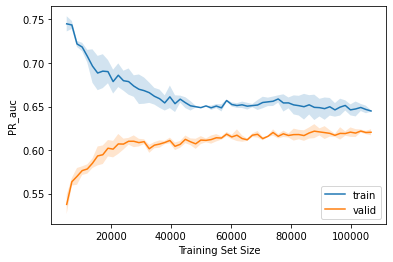

In [73]:
  
plot_learning_curve(val_train, val_test, train_sizes)

Судя по графику, можно предположить, что при увеличении количества наблюдений для пользователя 0128 PR_auc увеличится

Создадим и добавим новые признаки; проверим, как это отразится на качестве классификации

In [12]:
features_new_10 = feature_engineering(r"E:\Work\Project_capstone\10users", 
                                    session_length=16, window_size=6)

Преобразуем исходные новые признаки с помощью onehotencoder и нормализации

In [33]:
scaler =  MinMaxScaler()

In [41]:
norm_features_10 = scaler.transform(features_new_10.iloc[:, :2])

In [14]:
onehot_encoder = OneHotEncoder(sparse = True)

In [49]:
OHE_features_10 = onehot_encoder.transform(features_new_10.iloc[:, 2:])

In [81]:
OHE_features_10.shape

(23433, 40)

Соединяем разреженную матрицу, на которой мы обчались ранее с новой матрицей

In [61]:
X_new_10_16_6_test = hstack((X_sparse_10, OHE_features_10))

In [82]:
X_new_10_16_6_test.shape

(23433, 4953)

In [63]:
X_new_10_16_6 = hstack((X_sparse_10, OHE_features_10, norm_OHE_features_10))

In [83]:
X_new_10_16_6.shape

(23433, 4955)

Проверим, улучшилось ли значение accuracy после добавления новых признаков. Сначала - на LinearSVC

In [17]:
X_new_train_10_16_6, X_new_test_10_16_6, y_new_train_10_16_6, y_new_test_10_16_6 = \n
train_test_split(X_new_10_16_6, y_sparse_10,  test_size=0.3, random_state=17)

In [54]:
accuracy_score(y_new_test_10_16_6, LinearSVC(C=0.05, random_state = 17, multi_class = "ovr").fit(X_new_train_10_16_6, y_new_train_10_16_6).predict(X_new_test_10_16_6))

0.7879089615931721

Стало - 0,788. Было - 0,78. Попробуем изменить коэффициент регуляризации

In [56]:
%%time
svm_params3 = {'C': np.linspace(1e-3, 1, 20)}

svm_grid_searcher3 = GridSearchCV(estimator = LinearSVC(random_state = 17), param_grid = svm_params3, return_train_score = True)
svm_grid_searcher3.fit(X_new_train_10_16_6, y_new_train_10_16_6)

Wall time: 27min 24s


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ])},
             return_train_score=True)

Лучшее значение параметра регуляризации и соответсвующее значение accuracy

In [20]:
GridSearchCV?

In [ ]:
Б

In [59]:
svm_grid_searcher3.best_score_

0.7774170761442452

Лeчшее значение accuracy, полученное на кросс-валидации с помощью svm_grid_searcher2 на 0,007 меньше такового на svm_grid_searcher3. Добавление дополнительных признаков не даёт сльного прироста производительности модели. 

При кодировании avg_time_on_Site и session_timestamp с помощью OHE моель теряет в качестве. 

Проверим, как работает модель на данных по 150 пользователям

In [67]:
features_new_150 = feature_engineering(r"E:\Work\Project_capstone\150users", 
                                    session_length=16, window_size=6)

In [68]:
features_new_150 

,avg_time_on_site,session_timestamp,unique_sites,start_hour,day_of_week
0,10.0,167.0,7.0,8.0,4.0
1,105.0,1680.0,10.0,8.0,4.0
2,226.0,3626.0,8.0,8.0,4.0
3,127.0,2035.0,7.0,8.0,4.0
4,251.0,4019.0,7.0,8.0,4.0
...,...,...,...,...,...
1124,10.0,162.0,14.0,17.0,0.0
1125,0.0,7.0,13.0,17.0,0.0
1126,215602.0,3018439.0,14.0,17.0,0.0
1127,377304.0,3018437.0,9.0,17.0,0.0


In [69]:
X_sparse_150, y_sparse_150 = prepare_sparse_train_set_window_new(r"E:\Work\Project_capstone\150users", r"E:\Work\Project_capstone\site_freq_150users.pkl", 
                                    session_length=16, window_size=6)

In [70]:
norm_features_150 = scaler.transform(features_new_150.iloc[:, :2])

In [71]:
OHE_features_150 = onehot_encoder.transform(features_new_150.iloc[:, 2:])

In [74]:
X_new_150_16_6 = hstack((X_sparse_150, OHE_features_150, norm_features_150))

In [75]:
X_new_train_150_16_6, X_new_test_150_16_6, y_new_train_150_16_6, y_new_test_150_16_6 = train_test_split(X_new_150_16_6, y_sparse_150,  test_size=0.3, random_state=17)

In [76]:
accuracy_score(y_new_test_150_16_6, LinearSVC(C=0.05, random_state = 17, multi_class = "ovr").fit(X_new_train_150_16_6, y_new_train_150_16_6).predict(X_new_test_150_16_6))

0.6832223779490774

In [77]:
%%time
svm_params4 = {'C': np.linspace(1e-3, 1, 20)}

svm_grid_searcher3 = GridSearchCV(estimator = LinearSVC(random_state = 17), param_grid = svm_params4, return_train_score = True)
svm_grid_searcher3.fit(X_new_train_150_16_6, y_new_train_150_16_6)

Wall time: 9h 11min 5s


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ])},
             return_train_score=True)

тестирование модели, обученной при помощи новых признаков на новой выорке по 150 пользователям показало большую точность в сравнении с моделью, обученной исключительно на X_sparse и моделю с новыми ппризнаками, обученной на данных по 10 пользователям 

In [78]:
svm_grid_searcher3.best_score_

0.6874378314270848

Лучшее значение коэффициента регуляризации на кросс-валидации по данным по 150 пользователям с добавлением новых признаков составляет 0.3164736842105263

Выводы:
- Получена модель, способная с высокой точчностью идентифицировать пользователя среди прочих
- Оптимальная длина сессии, которую можно использовать для обучения составляет 16, а ширина окна - 6
- Лучше всего в данной задаче себя показала логистическая регрессия и SVM
- Добавление признаков помимо перечисления сайтов в определённом порядкев в рамках каждой из сессий даёт незначительный прирост в качестве
- Добавление большего числа данных не должно значительно улучшить качество предсказательной модели